# cosmodesi tutorial

## Overview

This tutorial builds on Arnaud's tutorial (), but it was thought

The main objective is to give a hands-on introduction to the different tools within the pipeline.

## cosmoprimo

Primordial cosmology package. Provides a consistent way to call and interact with your favourite Boltzmann codes (CAMB & CLASS). However it is more than just a wrapper!

In [1]:
from cosmoprimo import Cosmology, fiducial

# DESI fiducial cosmology
cosmo = fiducial.DESI()
type(cosmo)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cosmoprimo.cosmology.Cosmology

In [2]:
# explore some features
help(cosmo)

Help on Cosmology in module cosmoprimo.cosmology object:

class Cosmology(BaseCosmology)
 |  Cosmology(engine=None, extra_params=None, **params)
 |  
 |  Cosmology, defined as a set of parameters (and possibly a current engine attached to it).
 |  
 |  Method resolution order:
 |      Cosmology
 |      BaseCosmology
 |      cosmoprimo.utils.BaseClass
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __dir__(self)
 |      List of non-duplicate members from all sections.
 |      Adapted from https://github.com/bccp/nbodykit/blob/master/nbodykit/cosmology/cosmology.py.
 |  
 |  __eq__(self, other)
 |      Is ``other`` same as ``self``?
 |  
 |  __getattr__(self, name)
 |      Find the proper section, initialize it, and return its attribute.
 |      For example, calling ``cosmo.comoving_radial_distance`` will actually return ``cosmo.get_background().comoving_radial_distance``.
 |      Adapted from https://github.com/bccp/nbodykit/blob/master/nbodykit/cosmology/cosmology.py.
 

In [3]:
cosmo_new = Cosmology(engine='camb', **cosmo.params.copy())

Text(0.5, 0, '$\\ell$')

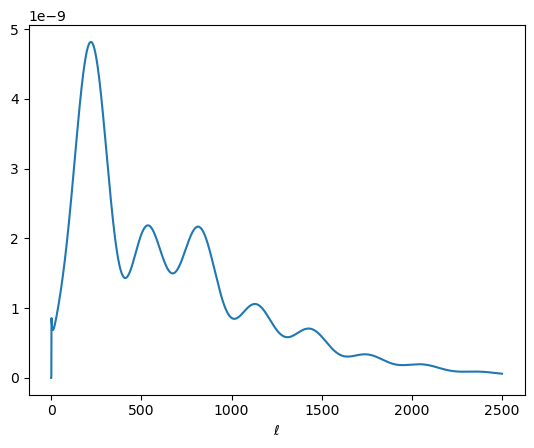

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
unCl = cosmo_new.unlensed_cl()
ell, tt = unCl['ell'], unCl['tt']
ax.plot(ell, ell * (ell + 1) * tt)
ax.set_xlabel(r'$\ell$')

#### Exercise
Create a cosmology instance with the same parameters as the DESI fiducial cosmology but with 10% more baryons. Plot the luminous distance for both cosmologies as a function of z.

## pypower
Power spectrum computation. Partly a re-implementation of some of nbodykit code, but with much more features!

In [5]:
from mockfactory import Catalog
import fitsio
import numpy as np

In [6]:
data = fitsio.read('mock_catalog.fits')
data['Position']

array([[1.02509156e+00, 9.95701004e+02, 9.88857284e+01],
       [2.53079416e+00, 2.17009176e+00, 2.46750674e+02],
       [9.97101107e+02, 9.93153205e+02, 3.78629646e+02],
       ...,
       [7.21251439e-02, 7.25624385e+00, 6.16206805e+02],
       [9.93954261e+02, 6.21134904e-02, 8.03775985e+02],
       [9.97612892e+02, 9.99989342e+02, 8.13936803e+02]])

In [13]:
data['Position'][:, 2] = data['Position'][:, 2] % 1000.

In [14]:
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
setup_logging()

In [15]:
power = CatalogFFTPower(data_positions1=data['Position'],
                        boxsize=1000., boxcenter=500.,
                        interlacing = 2, los='z',
                        edges={'step': 0.001}, ells=(0, 2),
                        position_type='pos', nmesh=128)

[000000.59]  08-11 15:17  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1000. 1000. 1000.], boxcenter=[500. 500. 500.], dtype=float64).
[000000.63]  08-11 15:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 999029.
[000001.29]  08-11 15:17  CatalogMesh                  INFO     Painted 999029 out of 999029 objects to mesh.
[000001.29]  08-11 15:17  CatalogMesh                  INFO     Running interlacing at order 2.
[000001.37]  08-11 15:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 999029.
[000001.97]  08-11 15:17  CatalogMesh                  INFO     Painted 999029 out of 999029 objects to mesh.
[000002.10]  08-11 15:17  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000002.10]  08-11 15:17  CatalogFFTPower              INFO     Using 402 k-bins between 0.000 and 0.402.
[000002.10]  08-11 15:17  CatalogFFTPower              INFO     Meshes prepared in elapsed time 1.51 s

<Axes: xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k P_{\\ell}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>

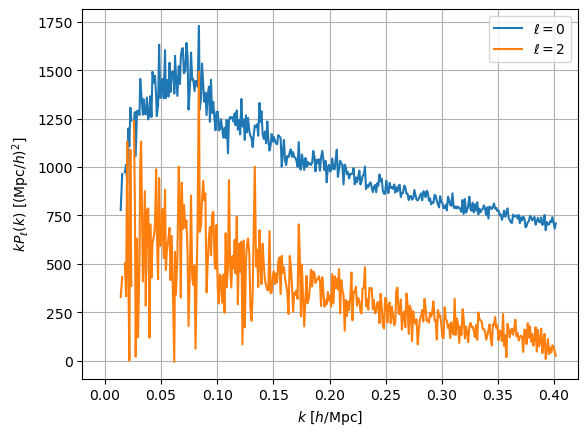

In [16]:
power.poles.plot()

#### Exercise
Rebin the power spectrum to dk=0.005 and compare the multipoles.

## pyrecon (?)

# desilike

In [43]:
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerCorrelationFunctionMultipoles
from desilike.observables.galaxy_clustering import TracerCorrelationFunctionMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.emulators import EmulatedCalculator

### Emulators